In [1]:
from front.dag import crudify_func_nodes
from streamlitfront.examples import simple_ml_1 as sml


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/sylvain/opt/anaconda3/envs/otopy38/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
audio_func = sml.audio_anomalies

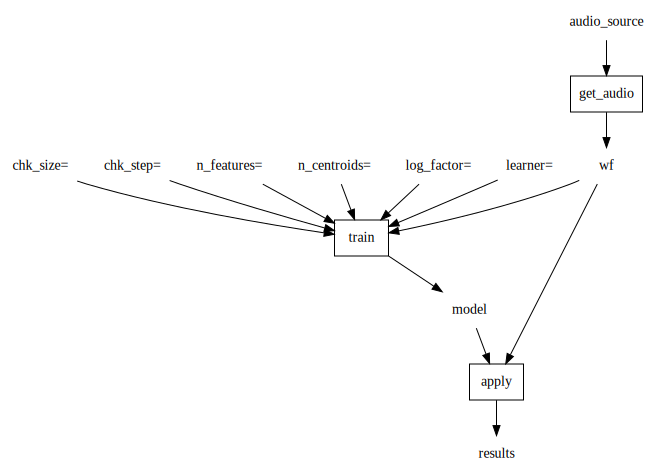

In [3]:
audio_func.dot_digraph()

In [11]:
from recode import decode_wav_bytes
from pathlib import Path
from operator import methodcaller, itemgetter
import numpy as np
from i2 import include_exclude
from i2 import Pipe
from streamlitfront.examples import simple_ml_1 as sml


from plunk.sb.front_demo.user_story1.utils.funcs import (
    learn_apply_model,
    upload_sound,
)
from meshed import code_to_dag

file_to_bytes = Pipe(Path, methodcaller('read_bytes'))
wav_file_to_array = Pipe(
    file_to_bytes, decode_wav_bytes, itemgetter(0), np.array, np.transpose, itemgetter(0)
)

def get_sound(audio_source, tag):
    return upload_sound(audio_source, "")[0]

@code_to_dag
def audio_anomalies():
    wf = get_audio(audio_source)
    model = train(learner, wf)
    results = apply(model, wf)

audio_anomalies = audio_anomalies.ch_funcs(
    get_audio=lambda audio_source: wav_file_to_array(audio_source),
    #get_audio = get_sound,
#     train=lambda wf, learner: auto_spectral_anomaly_learner(wf, learner=learner),
#     train=auto_spectral_anomaly_learner,
    train=include_exclude(sml.auto_spectral_anomaly_learner, include='wf learner', exclude=''),
    apply=lambda model, wf: model.score_samples(wf)
)

filepath = '/Users/sylvain/Dropbox/_odata/sound/guns/Sub-Machine Gun 9mm Long Burst 01.wav'
#filepath = '/Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/train/noise.AirConditioner_2.9.1440000-1600000.wav.23q8e34o.ingestion-6bc8b65f8c-vrv59.wav'

#wf = wav_file_to_array(filepath)

from omodel.outliers.pystroll import OutlierModel

results = audio_anomalies(filepath, learner=OutlierModel(n_centroids=5))
results.shape

AttributeError: 'function' object has no attribute 'score_samples'

In [9]:
wf

array([-2636, -2914, -3625, ...,    32,   111,   107])

In [12]:
# from streamlitfront.examples import simple_ml_1 as sml
from know.boxes import *
from streamlitfront.elements import FileUploader
from front import APP_KEY, RENDERING_KEY, ELEMENT_KEY, NAME_KEY
# from streamlitfront import mk_app, binder as b
from typing import Mapping
from dol import Pipe
from operator import methodcaller
from pathlib import Path
import numpy as np
from recode import decode_wav_bytes

from front.dag import crudify_funcs
from meshed import code_to_dag

from plunk.sb.front_demo.user_story1.utils.funcs import (
    learn_apply_model,
    upload_sound,
)
# from streamlitfront.elements import SelectBox

from slang import fixed_step_chunker, SpectralProjector

@code_to_dag
def audio_anomalies():
    wf = get_audio(audio_source, tag)
    model = train(learner, wf)
    results = apply(model, wf)


# filepath = /Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/train/noise.AirConditioner_2.9.1440000-1600000.wav.23q8e34o.ingestion-6bc8b65f8c-vrv59.wav

file_to_bytes = Pipe(Path, methodcaller('read_bytes'))
wav_file_to_array = Pipe(
    file_to_bytes,
    decode_wav_bytes,
    itemgetter(0),
    np.array,
    np.transpose,
    itemgetter(0),
)

from i2 import include_exclude, rm_params
from math import sqrt

def get_sound(audio_source, tag):
    return upload_sound(audio_source, '')[0]


# learner = OutlierModel()
# how to make that field appear correctly?
# convention: if value is an object, do crudification automatically: make a dict
# and give a name to it.
# TODO: names of funcs in the config should be actual names, not strings
# TODO: at least get some warnings when doing a config (like check args names)
# name-based routing: if func has this name, do this

def mk_featurizer(chk_size=2048, chk_step=None, n_features=4, log_factor: float = 2):
    return SpectralProjector.for_sizes(
        chk_size, n_features=n_features, log_factor=log_factor
    )


DFLT_N_FEATURES = 11


# @FuncFactory.wrap(exclude='wf')
def mk_wf_to_fvs(
    wf, chk_size=2048, chk_step=None, n_features=DFLT_N_FEATURES, log_factor: float = 2
):
    chunker = partial(fixed_step_chunker, chk_size=chk_size, chk_step=chk_step)
    featurizer = mk_featurizer(chk_size, n_features=n_features, log_factor=log_factor)
    return list(map(featurizer, chunker(wf)))


mk_wf_to_fvs = FuncFactory(mk_wf_to_fvs, exclude="wf")


# TODO: Make with meshed:
def auto_spectral_anomaly_learner(
    wf,
    chk_size=2048,
    chk_step=None,
    n_features=DFLT_N_FEATURES,
    n_centroids=None,
    log_factor: float = 2,
    learner=OutlierModel(),
    #     learner=GmmStroll(),
    #     learner=OneClassSVM(gamma='auto'),
):
    wf_to_fvs = mk_wf_to_fvs(
        chk_size=chk_size,
        chk_step=chk_step,
        n_features=n_features,
        log_factor=log_factor,
    )

    fvs = wf_to_fvs(wf)
    n_centroids = n_centroids or int(1 + sqrt(n_features))  # TODO: Be more scientific!
    model_obj = learner.fit(np.array(fvs).reshape((-1, 1)))

    def model_runner(wf):
        fvs = wf_to_fvs(wf)
        if callable(model_obj):
            return np.array(list(map(model_obj, fvs)))
        else:
            return model_obj.predict(fvs)

    return model_runner


audio_anomalies = audio_anomalies.ch_funcs(
    get_audio=lambda audio_source: wav_file_to_array(audio_source),
    #get_audio=get_sound,
    #     train=lambda wf, learner: auto_spectral_anomaly_learner(wf, learner=learner),
    #     train=auto_spectral_anomaly_learner,
    train=include_exclude(
        # sml.auto_spectral_anomaly_learner, include="wf learner", exclude=""
        auto_spectral_anomaly_learner,
        include='wf learner',
        # exclude="learner",
    ),
    # train=rm_params(
    #     # sml.auto_spectral_anomaly_learner, include="wf learner", exclude=""
    #     sml.auto_spectral_anomaly_learner,
    #     params_to_remove=("learner",),
    # ),
    # train=FuncFactory(
    #     # sml.auto_spectral_ano"maly_learner, include="wf learner", exclude=""
    #     sml.auto_spectral_anomaly_learner,
    #     # include="wf",
    #     exclude=("learner",),
    # ),
    apply=lambda model, wf: model(wf),
)

AssertionError: some bind keys weren't found as function argnames: tag

In [2]:
from omodel.outliers.pystroll import OutlierModel

results = audio_anomalies(filepath, tag='ok', learner=OutlierModel(n_centroids=5))
results.shape

TypeError: Got unexpected keyword arguments: tag

In [3]:
# from streamlitfront.examples import simple_ml_1 as sml
from know.boxes import *
from streamlitfront.elements import FileUploader
from front import APP_KEY, RENDERING_KEY, ELEMENT_KEY, NAME_KEY
# from streamlitfront import mk_app, binder as b
from typing import Mapping
from dol import Pipe
from operator import methodcaller
from pathlib import Path
import numpy as np
from recode import decode_wav_bytes

from front.dag import crudify_funcs
from meshed import code_to_dag

from plunk.sb.front_demo.user_story1.utils.funcs import (
    learn_apply_model,
    upload_sound,
)
# from streamlitfront.elements import SelectBox


@code_to_dag
def audio_anomalies():
    wf = get_audio(audio_source)
    model = train(learner, wf)
    results = apply(model, wf)


filepath = "/Users/sylvain/Dropbox/_odata/sound/guns/01 Gunshot Pistol - Small Caliber - 18 Versions.wav"

file_to_bytes = Pipe(Path, methodcaller('read_bytes'))
wav_file_to_array = Pipe(
    file_to_bytes,
    decode_wav_bytes,
    itemgetter(0),
    np.array,
    np.transpose,
    itemgetter(0),
)

from i2 import include_exclude, rm_params


def get_sound(audio_source, tag):
    return upload_sound(audio_source, '')[0]


# learner = OutlierModel()
# how to make that field appear correctly?
# convention: if value is an object, do crudification automatically: make a dict
# and give a name to it.
# TODO: names of funcs in the config should be actual names, not strings
# TODO: at least get some warnings when doing a config (like check args names)
# name-based routing: if func has this name, do this

def mk_featurizer(chk_size=2048, chk_step=None, n_features=4, log_factor: float = 2):
    return SpectralProjector.for_sizes(
        chk_size, n_features=n_features, log_factor=log_factor
    )


DFLT_N_FEATURES = 11


# @FuncFactory.wrap(exclude='wf')
def mk_wf_to_fvs(
    wf, chk_size=2048, chk_step=None, n_features=DFLT_N_FEATURES, log_factor: float = 2
):
    chunker = partial(fixed_step_chunker, chk_size=chk_size, chk_step=chk_step)
    featurizer = mk_featurizer(chk_size, n_features=n_features, log_factor=log_factor)
    return list(map(featurizer, chunker(wf)))


mk_wf_to_fvs = FuncFactory(mk_wf_to_fvs, exclude="wf")


# TODO: Make with meshed:
def auto_spectral_anomaly_learner(
    wf,
    chk_size=2048,
    chk_step=None,
    n_features=DFLT_N_FEATURES,
    n_centroids=None,
    log_factor: float = 2,
    learner=OutlierModel(),
    #     learner=GmmStroll(),
    #     learner=OneClassSVM(gamma='auto'),
):
    wf_to_fvs = mk_wf_to_fvs(
        chk_size=chk_size,
        chk_step=chk_step,
        n_features=n_features,
        log_factor=log_factor,
    )

    fvs = wf_to_fvs(wf)
    n_centroids = n_centroids or int(1 + sqrt(n_features))  # TODO: Be more scientific!
    model_obj = learner.fit(np.array(fvs).reshape((-1, 1)))

    def model_runner(wf):
        fvs = wf_to_fvs(wf)
        if callable(model_obj):
            return np.array(list(map(model_obj, fvs)))
        else:
            return model_obj.predict(fvs)

    return model_runner


audio_anomalies = audio_anomalies.ch_funcs(
    get_audio=lambda audio_source: wav_file_to_array(audio_source),
    #get_audio=get_sound,
    #     train=lambda wf, learner: auto_spectral_anomaly_learner(wf, learner=learner),
    #     train=auto_spectral_anomaly_learner,
    train=include_exclude(
        # sml.auto_spectral_anomaly_learner, include="wf learner", exclude=""
        auto_spectral_anomaly_learner,
        include='wf learner',
        # exclude="learner",
    ),
    # train=rm_params(
    #     # sml.auto_spectral_anomaly_learner, include="wf learner", exclude=""
    #     sml.auto_spectral_anomaly_learner,
    #     params_to_remove=("learner",),
    # ),
    # train=FuncFactory(
    #     # sml.auto_spectral_ano"maly_learner, include="wf learner", exclude=""
    #     sml.auto_spectral_anomaly_learner,
    #     # include="wf",
    #     exclude=("learner",),
    # ),
    apply=lambda model, wf: model(wf),
)

In [4]:
wf = wav_file_to_array(filepath)
wf

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
mall = dict()
_funcs = crudify_funcs(var_nodes="wf model results", dag=audio_anomalies, mall=mall)


In [12]:
def foo(x, y, z="23"):
    return int(x) + int(y) * int(z)


def bar(res, other="stuff"):
    return f"{res=}, {other=}"


@code_to_dag
def dag():
    res = first_func(x, y, z)
    result = second_func(res, other)


dag = dag.ch_funcs(
    first_func=rm_params(foo, params_to_remove=("z",)),
    second_func=bar,
)


NameError: name 'foo' is not defined